In [9]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Dataset

In [10]:
from poc_data import PocDataset

poc_raw_dataset = PocDataset(num_cases=1024)
data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=16)
batch, event, time_to_event, _latent_variable = next(iter(data_loader))

print(batch.shape)
print(event.shape)
print(time_to_event.shape)
print(_latent_variable.shape)

torch.Size([16, 30, 3])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
tensor([[6.9852e-01],
        [1.2600e-01],
        [3.3041e-01],
        [9.0690e-01],
        [4.3215e-01],
        [5.5244e-01],
        [4.3617e-02],
        [4.1538e-01],
        [4.0747e-01],
        [7.1158e-01],
        [4.3437e-02],
        [2.9486e-02],
        [4.1609e-01],
        [6.5130e-04],
        [4.3230e-01],
        [4.7694e-01]])


### Data Exploration

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.]])
tensor([[21.],
        [ 4.],
        [10.],
        [27.],
        [13.]])
tensor([[0.6985],
        [0.1260],
        [0.3304],
        [0.9069],
        [0.4322]])


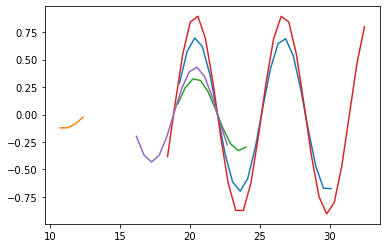

In [23]:
#Take a look at the longitudional data

plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

print(event[:5])
print(time_to_event[:5])
print(_latent_variable[:5])


# 2. Hyperparameters

# 3. Defining The Model